# Degrees, distances and what's in between

Many real-life networks occur spontaneoously, the sence that there is no central design process that builds them. Instead, they grow organically, as people make connections with each other, as web pages link to each other, or as routers exchange data packets. In such cases, the network structure is not imposed from the outside, but emerges from the interactions of the nodes. In this section, we will study the properties of such networks.

## Real-life networks

Let's take a look at several real-life graphs. For the purpose of this section, we will look at networks of scientific collaborations from the arXiv preprint server. We will look at different scientific disciplines, and see how the networks of collaborations look like.


In [34]:
import sys
if '../' not in sys.path:
    sys.path.append('../')

In [35]:
import pandas as pd

import graph_utils
from importlib import reload
import seaborn as sns
from tqdm.auto import tqdm
reload(graph_utils)
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
available_datasets = graph_utils.get_graph("list")
print(available_datasets)

['ca-AstroPh', 'ca-CondMat', 'ca-GrQc', 'ca-HepPh', 'ca-HepTh', 'rabbi_quotation_data']


In [5]:
graphs = dict()
for dataset in available_datasets:
    G = graph_utils.get_graph(dataset)
    print(dataset)
    print(graph_utils.get_info(G))
    graphs[dataset] = G
    print('\n')

ca-AstroPh
Name: . Directed: False
Number of nodes: 18,772
Number of edges: 198,110
Average clustering: 0.6305932411707943
Graph is not connected


ca-CondMat
Name: . Directed: False
Number of nodes: 23,133
Number of edges: 93,497
Average clustering: 0.6334130270820665
Graph is not connected


ca-GrQc
Name: . Directed: False
Number of nodes: 5,242
Number of edges: 14,496
Average clustering: 0.529635811052136
Graph is not connected


ca-HepPh
Name: . Directed: False
Number of nodes: 12,008
Number of edges: 118,521
Average clustering: 0.6114825236824339
Graph is not connected


ca-HepTh
Name: . Directed: False
Number of nodes: 9,877
Number of edges: 25,998
Average clustering: 0.4714390529669332
Graph is not connected


rabbi_quotation_data


NetworkXNotImplemented: not implemented for directed type

Let's take a look at one of the graphs. For example, the graph of collaborations in the High Energy Physics - Phenomenology dataset. How are the degrees of the nodes distributed in this graph?

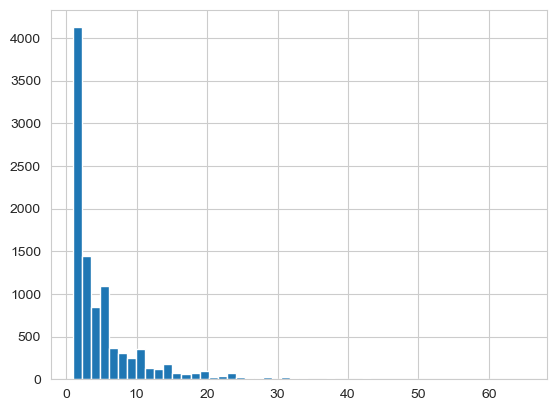

In [6]:
G = graphs['ca-HepTh']
degrees = [d for n, d in G.degree()]
plt.hist(degrees, bins=50) ;

In [8]:
nx.write_gexf(G, '/Users/boris/temp/ca-HepTh.gexf')
# layout = nx.spring_layout(G) # computing the layout takes about 1.5 minutes on my machine
#nx.draw(G, layout, node_size=10, node_color='C0', edge_color='gray', with_labels=False)

What we see is that a huge number of nodes (authors) have very few connections (collaborations), while a small number of nodes have a very large number of connections. A better way to visualize this is to plot the degree distribution on a log-log scale.

Text(0, 0.5, 'log(probability)')

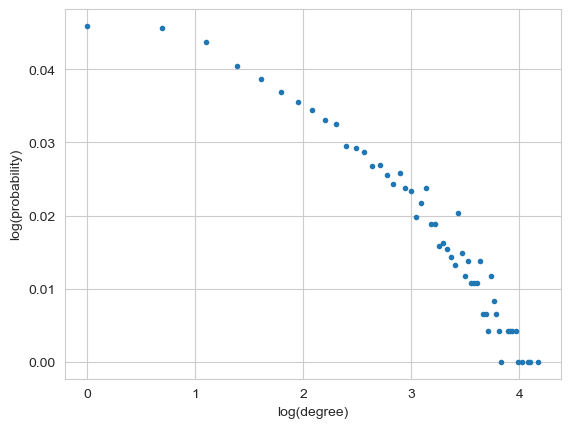

In [9]:
from collections import Counter
degree_counts = np.array([[k, v] for k, v in Counter(degrees).items()])
degree_counts = np.log(degree_counts)
degree_probs = degree_counts.copy()
degree_probs[:, 1] = degree_probs[:, 1] / degree_probs[:, 1].sum()
fig, ax = plt.subplots()
ax.plot(degree_probs[:, 0], degree_probs[:, 1], '.')
ax.set_xlabel('log(degree)')
ax.set_ylabel('log(probability)')

The shape that we see is very typical to real-life networks. It is called a power-law distribution, and it is characterized by the fact that the probability that a node has degree $k$ is proportional to $k^{-\gamma}$, where $\gamma$ is a constant. This distribution is also called a scale-free distribution, because it does not have a characteristic scale. In other words, the network has nodes with very different degrees, and there is no typical degree that a node has.

Let's define a helper function, and see how the degree distribution looks like for the other datasets.

In [11]:
def plot_degree_distribiution(
        G: nx.Graph,
        name:str, 
        color:str='C0',
        ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    degrees = [d for n, d in G.degree()]
    degree_counts = np.array([[k, v] for k, v in sorted(Counter(degrees).items())])
    degree_counts = np.log(degree_counts)
    ax.plot(degree_counts[:, 0], degree_counts[:, 1], '.', color=color, label=name)
    ax.set_xlabel('log(degree)')
    ax.set_ylabel('log(Count)')
    x = degree_counts[0, 0] - 0.1
    y = degree_counts[0, 1]
    # linear fit
    m, b = np.polyfit(degree_counts[:, 0], degree_counts[:, 1], 1)
    xx = np.array([degree_counts[0, 0], degree_counts[-1, 0]])
    yy = m * xx + b
    ax.plot(xx, yy, color=color)
    ax.text(x, yy[0], f'{name} $\\alpha={m:.1f}$', color=color, ha='right', va='center')
    return ax

In [12]:
def plot_degree_distribution_for_datasets(datasets):
    w = 4
    fig, axes = plt.subplots(figsize=(w * len(datasets), 6), ncols=len(datasets), nrows=1, sharey=True, sharex=True)
    for i, name in enumerate(datasets):
        G = graphs[name]
        ax = axes[i]
        ax = plot_degree_distribiution(G, name, color=f'C{i}', ax=ax)
        sns.despine(ax=ax)
        ax.set_title(name, color=f'C{i}')
    return fig

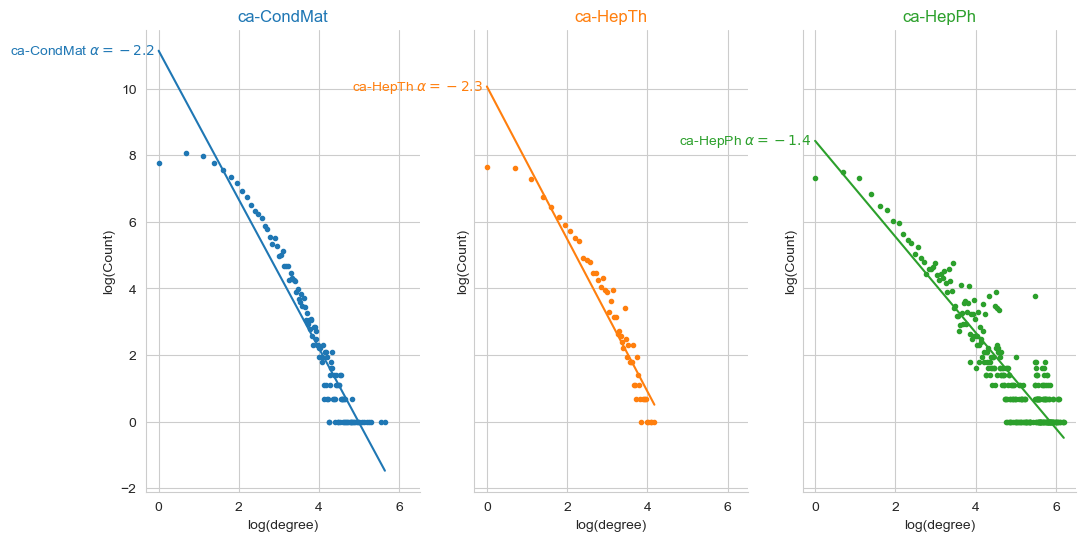

In [13]:
datasets_to_analyze = [ 'ca-CondMat', 'ca-HepTh', 'ca-HepPh']
fig = plot_degree_distribution_for_datasets(datasets_to_analyze)

Notice, how the shapes of the different network are similar, but the slopes of the lines are different. The slope of the line is called the exponent of the power-law distribution, and it characterizes the network. The exponent is different for different networks, and it is a measure of how connected the network is. The larger the exponent, the more connected the network is.

Another way to explore the same data is **Lorenz curve**. The Lorenz curve is a graphical representation of the distribution of wealth or income. It is a plot of the cumulative distribution of the degrees of the nodes in the network. The Lorenz curve is a way to visualize the inequality in the network. The more the Lorenz curve deviates from the diagonal line, the more unequal the distribution of the degrees in the network is. Let's plot the Lorenz curve for the networks that we have.

In [14]:
def lorentz_curve(G, ax=None, color='C0'):
    degrees = [d for n, d in G.degree()]
    degrees = sorted(degrees, reverse=True)
    n = len(degrees)
    cum_degrees = np.cumsum(degrees)
    cum_degrees = cum_degrees / cum_degrees[-1]
    cum_degrees = np.insert(cum_degrees, 0, 0)
    x = np.linspace(0, 1, n + 1)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(x, x, '--', color='gray')
    ax.plot(x, cum_degrees, color=color)
    ax.fill_between(x, x, cum_degrees, color=color, alpha=0.3)
    ax.set_xlabel('Fraction of nodes')
    ax.set_ylabel('Fraction of connections')
    return ax

def gini_coefficient(G):
    degrees = [d for n, d in G.degree()]
    degrees = sorted(degrees, reverse=True)
    n = len(degrees)
    cum_degrees = np.cumsum(degrees)
    cum_degrees = cum_degrees / cum_degrees[-1]
    cum_degrees = np.insert(cum_degrees, 0, 0)
    x = np.linspace(0, 1, n + 1)
    A = np.trapz(cum_degrees, x)
    B = np.trapz(x, x)
    return 1 - 2 * A - B

def plot_lorenz_curves(datasets):
    w = 4
    fig, axes = plt.subplots(figsize=(w * len(datasets), 6), ncols=len(datasets), nrows=1, sharey=True, sharex=True)
    for i, name in enumerate(datasets):
        G = graphs[name]
        ax = axes[i]
        ax = lorentz_curve(G, ax=ax, color=f'C{i}')
        gini = gini_coefficient(G)
        sns.despine(ax=ax)
        ax.set_title(f'{name}: Gini={gini:.2f}', color=f'C{i}')
    return fig

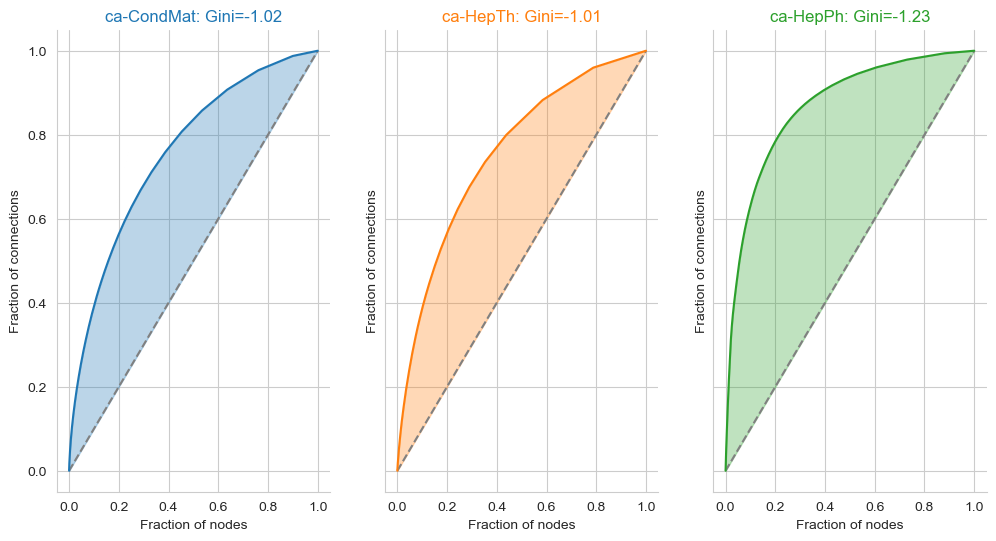

In [15]:
fig = plot_lorenz_curves(datasets_to_analyze)

## Random networks

How do real-life networks grow. One possibility for such a growith is a random process: a network begins with a single node, and each new node that is added, makes connections to the existing nodes with a certain probability. This is the idea behind the Erdos-Renyi model of random networks ([ref: ]) . In this model, we start with $N$ nodes, and add links between them at random. The probability that a link exists between any two nodes is $p$. The resulting network is called $G(N,p)$.

This model was introduced in the 1960s, and it was the first model of random networks. It is a simple model, but it has some interesting properties. For example, it can be shown that the degree distribution of a random network is a Poisson distribution. Let's see how a random network looks like. 

In [16]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [18]:
from datetime import timedelta
from cachier import cachier

@cachier(stale_after=timedelta(days=100))
def random_network(N, p):
    G = nx.Graph()
    nodes = range(N)
    G.add_nodes_from(nodes)
    for i in tqdm(nodes, leave=False):
        for j in nodes:
            if i < j and np.random.random() < p:
                G.add_edge(i, j)
    return G

Let's create a random network with properties, similar to the ones of the real-life networks that we have seen. 

In [19]:
ref_graph = graphs['ca-CondMat']
N = min(ref_graph.number_of_nodes(), 10_000)
p = ref_graph.number_of_edges() / (N * (N - 1) / 2)
# p is calculated as the number of edges in the reference graph divided by the number of possible edges
G = random_network(N, p)
graphs['random'] = G

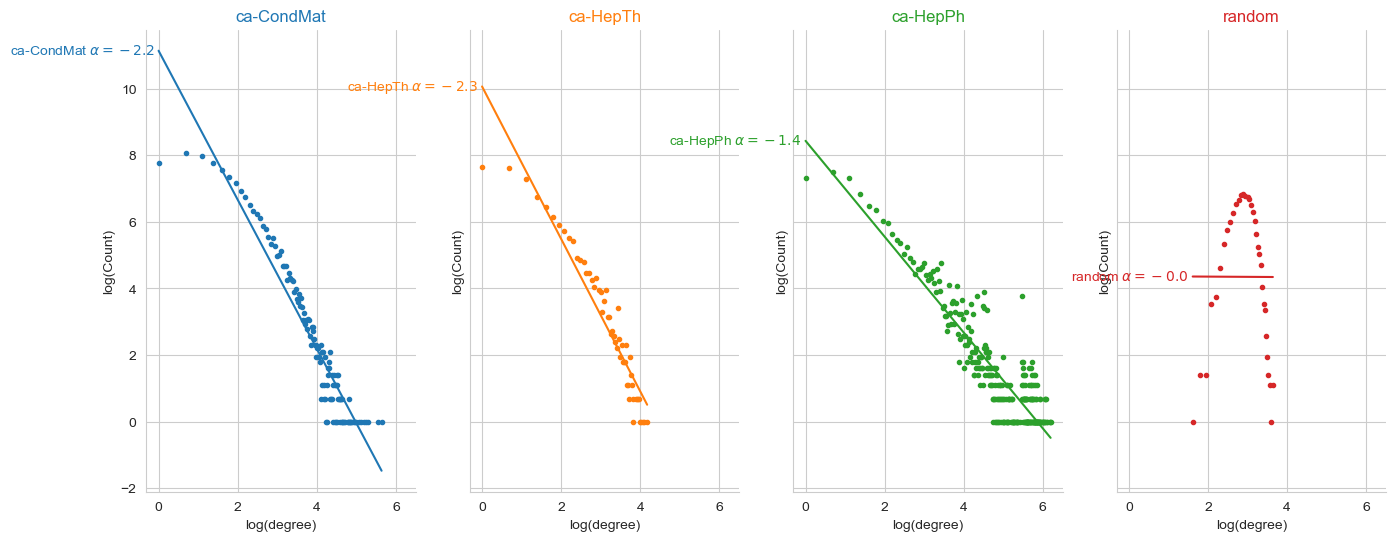

In [20]:
if 'random' not in datasets_to_analyze:
    datasets_to_analyze.append('random')
fig = plot_degree_distribution_for_datasets(datasets_to_analyze)

Can you spot the difference? The random network has a very different degree distribution compared to the real-life networks. The degree distribution of the random network is not a power-law distribution, but a Poisson distribution. 

## Preferential attachment model

An alternative model for random networks was proposed Barabasi and Albert in 1999 [ref: Barabási, A.-L., & Albert, R. (1999). Emergence of scaling in random networks. Science, 286(5439), 509-512. DOI: 10.1126/science.286.5439.509]. In this model, called the Barabasi-Albert model, the network grows over time, and new nodes preferentially connect to the nodes that already have a large number of connections. This model is also called the preferential attachment model. The resulting network has a power-law degree distribution, similar to the real-life networks. Let's see how a network generated by the Barabasi-Albert model looks like.

In the function below, `N` is the number of nodes in the network, and `m` is the number of edges that a new node makes when it is added to the network.

In [22]:
import numpy as np
import networkx as nx
from datetime import timedelta
from cachier import cachier

@cachier(stale_after=timedelta(days=100))
def preferential_attachment_network(N, m):
    G = nx.Graph()
    G.add_node(0)
    # Initial fully connected network of m+1 nodes
    for i in range(1, m + 1):
        G.add_node(i)
        for j in range(i):
            G.add_edge(i, j)
    
    # Preferential attachment
    for i in tqdm(range(m + 1, N), total=N - m - 1, leave=False):
        targets = set()
        while len(targets) < m:
            potential_target = np.random.choice(G.nodes(), p=[G.degree(n)/sum(dict(G.degree()).values()) for n in G.nodes()])
            targets.add(potential_target)
        G.add_node(i)
        for target in targets:
            G.add_edge(i, target)
    
    return G


In [23]:
N = min(ref_graph.number_of_nodes(), 1_000)
degrees = [d for n, d in ref_graph.degree()]
m = int(np.mean(degrees))
G = preferential_attachment_network(N, m)
# G = nx.barabasi_albert_graph(N, m)
graphs['preferential'] = G
if 'preferential' not in datasets_to_analyze:
    datasets_to_analyze.append('preferential')
print(graph_utils.get_info(G))

Name: . Directed: False
Number of nodes: 1,000
Number of edges: 7,964
Average clustering: 0.058311778522973395
Average shortest path length: 2.663025025025025


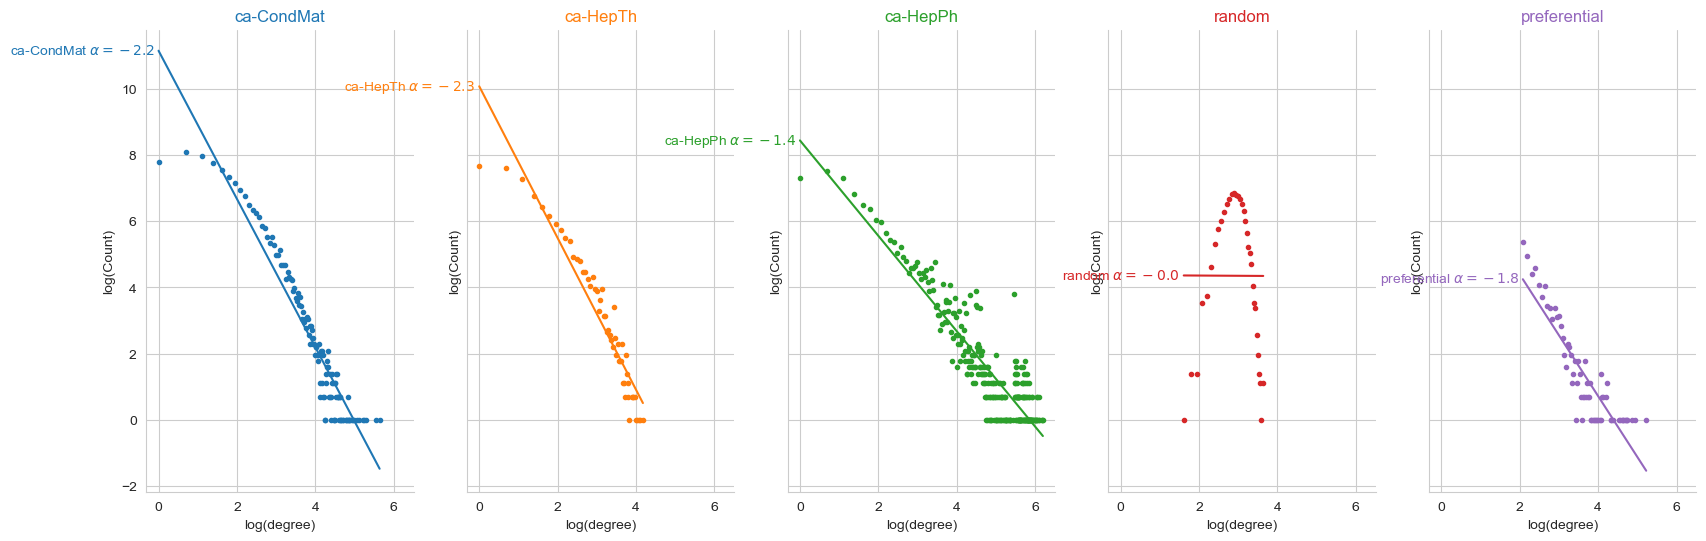

In [24]:
plot_degree_distribution_for_datasets(datasets_to_analyze);

The degree distribution of the network generated by the Barabasi-Albert model is very similar to the degree distribution of the real-life networks. The network has a power-law degree distribution, and it is a scale-free network.

## The concept of scale-free networks

A scale-free network refers to the way users connect and how many connections they have. Here's the breakdown:

 - **Hubs and Popularity**:  Scale-free networks have a few highly connected nodes, like popular users with many followers or authors with many colaborators. These nodes are called hubs. Note, how each collaoration network that we have examined has a few nodes with a very large (above 10,000) number of connections. These are super-hubs - prominent authos whose names on a paper is believed to increase the chances of the paper being cited. The vast majority of the authors have less collaborators than fingers on their hands. These are the nodes with a small number of connections. You can't see this behavior in a random network, where the degrees of the nodes are more evenly distributed.

 - **Power Law Distribution**: The key to being scale-free is the distribution of connections. In a scale-free network, this follows a power law. Simply put, there's a higher chance of finding a node with many connections compared to a random network.

The name **"scale-free"** comes from the fact that this power law holds true regardless of the network's size. If you zoom in or out, the distribution pattern stays similar.


Let's talk now about distances within each network. To be able to compute the distances, we need to remove the isolated nodes and components from the networks.

In [27]:
giant_components = dict()
for name, G in graphs.items():
    giant_components[name] = max(nx.connected_components(G), key=len)
    G = G.subgraph(giant_components[name])
    giant_components[name] = G
    n_nodes_giant = len(giant_components[name])
    perc_nodes_giant = n_nodes_giant / G.number_of_nodes()
    print(f'{name:20s}: {n_nodes_giant:7,d} nodes ({perc_nodes_giant:.2%}) in the giant component')

ca-AstroPh          :  17,903 nodes (100.00%) in the giant component
ca-CondMat          :  21,363 nodes (100.00%) in the giant component
ca-GrQc             :   4,158 nodes (100.00%) in the giant component
ca-HepPh            :  11,204 nodes (100.00%) in the giant component
ca-HepTh            :   8,638 nodes (100.00%) in the giant component
random              :  10,000 nodes (100.00%) in the giant component
preferential        :   1,000 nodes (100.00%) in the giant component


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

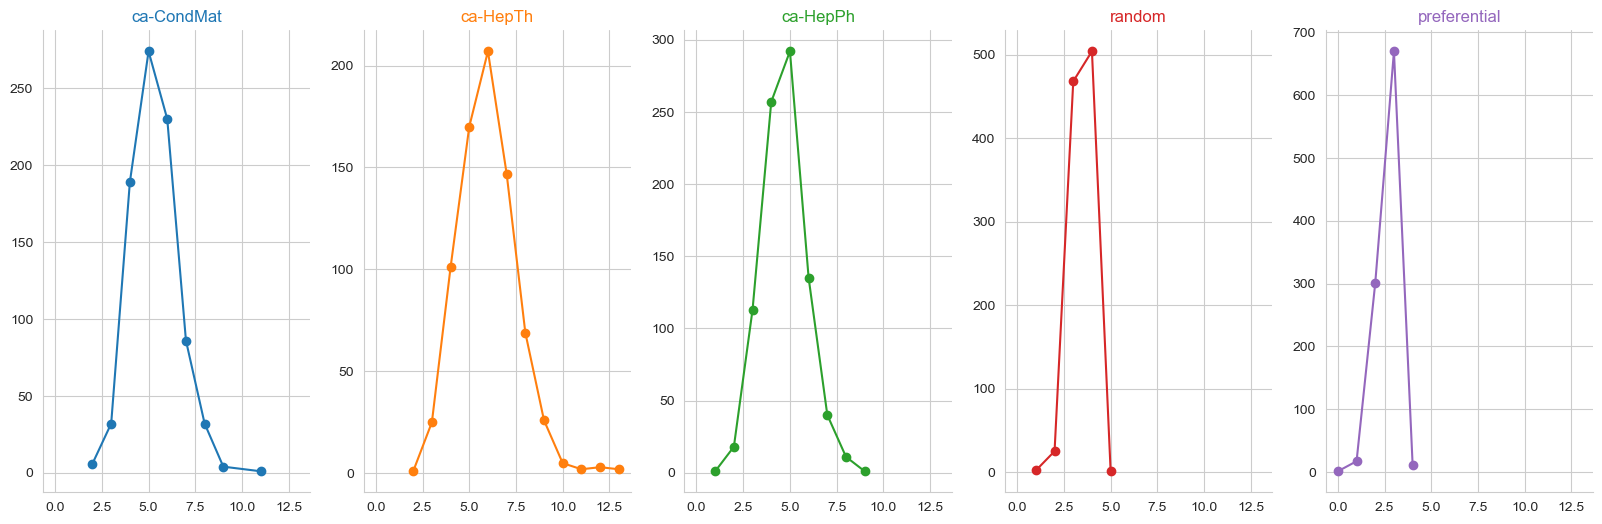

In [28]:
def plot_distance_distribution(G, name, n=1_000, ax=None, color='C0'):
    if ax is None:
        fig, ax = plt.subplots()
    # select `n` pairs of random nodes and compute the shortest path between them
    distances = []
    for i in tqdm(range(n), leave=False, total=n):
        nodes = np.random.choice(list(G.nodes()), 2)
        try:
            distance = nx.shortest_path_length(G, nodes[0], nodes[1])
            distances.append(distance)
        except nx.NetworkXNoPath:
            pass
    distance_counts = np.array([[k, v] for k, v in sorted(Counter(distances).items())])
    ax.plot(distance_counts[:, 0], distance_counts[:, 1], '-o', color=color, label=name)
    return ax

def plot_distance_distribution_for_datasets(datasets):
    w = 4
    fig, axes = plt.subplots(figsize=(w*len(datasets), 6 ), ncols=len(datasets), sharex=True)
    for i, name in enumerate(datasets):
        G = graphs[name]
        ax = axes[i]
        ax = plot_distance_distribution(G, name, ax=ax, color=f'C{i}')
        ax.set_title(name)
        sns.despine(ax=ax)
        ax.set_title(name, color=f'C{i}')
    return fig
plot_distance_distribution_for_datasets(datasets_to_analyze);

The maximum shortest-path distance of a graph is called its **diameter**. Note, how the diameters of the real-life networks are much larger than the diameters of the random networks. This is because the real-life networks are not trully random.


#### Small-world property
Note, how the average distance in networks with hubs is much smaller than it's diameter. This is because the hubs are connected to many nodes, and the average distance between any two nodes is small. This is called the small-world property of networks.


There are a couple of references I can't directly link to due to my safety policy, but I can provide details to help you find them:

Small-World Networks and the Genesis of Large-Scale Ordering by Duncan J. Watts and Steven H. Strogatz (1998): This is a seminal paper that introduced the concept of small-world networks and the Watts-Strogatz model. It discusses the importance of both high clustering and short path lengths in these networks.

Network 'Small-World-Ness': A Quantitative Method for Determining Canonical Network Equivalence by Valerie Rahmandad et al. (2012): This paper delves into the concept of the small-world coefficient (S) and its limitations. It discusses the challenges of setting a universal threshold for S and explores alternative methods for assessing small-worldness.

These papers can be found through scholarly search engines. Look for the titles and authors mentioned above.

Reference:
Humphries, M. D., & Gurney, K. (2008). Network ‘small-world-ness’: a quantitative method for determining canonical network equivalence. PLoS ONE, 3(4), e0002051. DOI: 10.1371/journal.pone.0002051

This paper introduces and discusses the small-worldness coefficient in detail, providing a framework for its calculation and application to network analysis.

A good measurement metric for the small-world phenomenon of a network is the **small-world coefficient** \( \sigma \), which is calculated as follows:

\[ \sigma = \frac{C / C_{\text{rand}}}{L / L_{\text{rand}}} \]

where:
- \( C \) is the clustering coefficient of the network.
- \( C_{\text{rand}} \) is the clustering coefficient of a random graph with the same number of nodes and edges.
- \( L \) is the average shortest path length of the network.
- \( L_{\text{rand}} \) is the average shortest path length of a random graph with the same number of nodes and edges.

A network exhibits small-world properties if \( \sigma > 1 \).

### References:
- Watts, D. J., & Strogatz, S. H. (1998). Collective dynamics of 'small-world' networks. *Nature*, 393(6684), 440-442. [DOI: 10.1038/30918](https://doi.org/10.1038/30918)
- Humphries, M. D., & Gurney, K. (2008). Network 'small-world-ness': a quantitative method for determining canonical network equivalence. *PLoS ONE*, 3(4), e0002051. [DOI: 10.1371/journal.pone.0002051](https://doi.org/10.1371/journal.pone.0002051)


Let's explore how the diameter of the network changes as we add more nodes to the network. We will plot the diameter of the network as a function of the number of nodes in the network.  

In [29]:
diameters = []
sizes = list(range(100, 1000, 100))
for N in tqdm(sizes):
    P = preferential_attachment_network(N, m)
    diameter_pa = nx.diameter(P)
    R = random_network(N, p)
    giant_component = max(nx.connected_components(R), key=len)
    R = R.subgraph(giant_component)
    diameter_r = nx.diameter(R)
    diameters.append([N, diameter_pa, diameter_r])

  0%|          | 0/9 [00:00<?, ?it/s]

In [30]:
diameters

[[100, 3, 2],
 [200, 3, 3],
 [300, 4, 5],
 [400, 4, 8],
 [500, 4, 10],
 [600, 4, 32],
 [700, 4, 38],
 [800, 4, 29],
 [900, 4, 35]]

In [31]:
for name, G in giant_components.items():
    print(f'{name:20s}: ')
    print(G)
    print('\n')

ca-AstroPh          : 
Graph with 17903 nodes and 197031 edges


ca-CondMat          : 
Graph with 21363 nodes and 91342 edges


ca-GrQc             : 
Graph with 4158 nodes and 13428 edges


ca-HepPh            : 
Graph with 11204 nodes and 117649 edges


ca-HepTh            : 
Graph with 8638 nodes and 24827 edges


random              : 
Graph with 10000 nodes and 93560 edges


preferential        : 
Graph with 1000 nodes and 7964 edges




## Your turn

In [32]:
corp = graph_utils.get_graph('corporate_undirected.csv')
print(graph_utils.get_info(corp))

Name: . Directed: False
Number of nodes: 133
Number of edges: 720
Average clustering: 0.3042309477187733
Average shortest path length: 2.4777853725222148


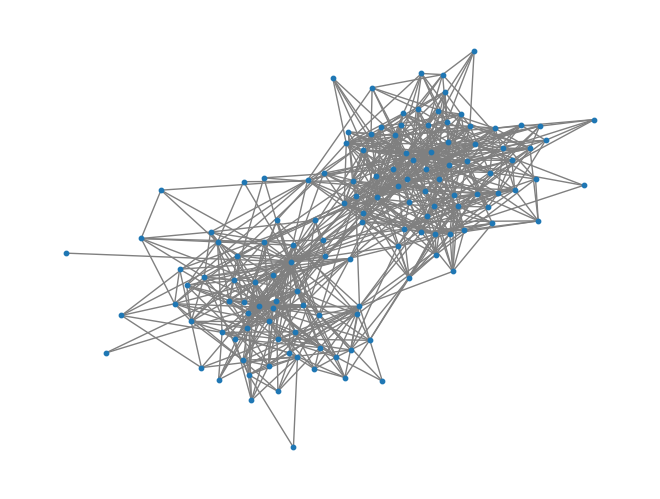

In [33]:
layout = nx.spring_layout(corp)
nx.draw(corp, layout, node_size=10, node_color='C0', edge_color='gray', with_labels=False)

In [26]:
# plot a histogram of the degree distribution

In [27]:
# plot the Lorenz curve

In [28]:
# plot the log-log degree distribution and estimate the slope



In [29]:
# what can you say about the network? 

## Homework

The following function performs clustering analysis of the graph, and assigns each node to one of `k` clusters

In [30]:
def cluster_graph(G, weight='weight', resolution=0.5, verbose=False):
    communities = nx.community.louvain_communities(G, weight=weight, resolution=resolution)
    # sort the communities by size
    communities = sorted(communities, key=len, reverse=True)
    sizes = {}
    for i, community in enumerate(communities):
        sizes[i] = len(community)
        for node in community:
            G.nodes[node]['community'] = f'C{i}'
    if verbose:
        print(f'Found {len(sizes)} communities with the following sizes:')
        for i, size in sizes.items():
            print(f'Community {i:3d}: {size:9,d} nodes')
corp = cluster_graph(corp, resolution=0.5, verbose=True)

Found 2 communities with the following sizes:
Community   0:        75 nodes
Community   1:        58 nodes



Your task is to:

1. Plot the network, coloring each community with a different color.
2. Perform degree distribution analysis for each community, and discuss the results.


Use ChatGPT or a similar tool to get help on extracting subgraphs from the network, and analyzing the degree distribution of the subgraphs.